In [60]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import DataLoader, random_split
import torchmetrics
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from tqdm import tqdm
from PIL import Image
import cv2 as cv
import seaborn as sns

import os
import segmentation_models_pytorch as smp

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)

cuda:0


In [3]:
JSON_FILE = r"HuBMAP dataset\polygons.jsonl"
IMG_PATH = r"HuBMAP dataset\imgs"
TILE_META_PATH = r"HuBMAP dataset\tile_meta.csv"

MODEL_PATH = r"models\cv\best__wsi1.pt"

SEED = 42

In [4]:
def show_masked(img, mask, ax):
    mask_full = np.zeros_like(img, dtype=np.uint8)
    mask_full[:,:,0] = mask
    masked_img = cv.bitwise_or(img, mask_full)
    return ax.imshow(masked_img)


def img_denorm(x):
    x = x + np.abs(x.min())
    x = x/x.max()
    x = x * 255
    x = x.astype(np.uint8)

    return x

In [5]:
class HubmapDataset(Dataset):

    def __init__(self, json_file=JSON_FILE,
                 images_path=IMG_PATH,
                 tile_meta_path=TILE_META_PATH,
                 wsi_n=1,
                 test=True,
                 return_stack=False):

        self.test = test
        self.wsi_n = wsi_n
        self.tile_meta = tile_meta_path
        self.polygons = json_file
        self.images_path = images_path
        self.return_stack = return_stack

    def __len__(self):
        return len(self.polygons)

    @property
    def tile_meta(self):
        return self.__tile_meta

    @tile_meta.setter
    def tile_meta(self, val):
        with open(val) as f:
            tile_file = pd.read_csv(f)
            if self.test:
                tile_file = tile_file[tile_file.source_wsi == self.wsi_n].reset_index(drop=True)
            else:
                tile_file = tile_file[tile_file.source_wsi.isin([n for n in [1,2,3,4] if n!=self.wsi_n])].reset_index(drop=True)
            self.__tile_meta = tile_file

    @property
    def polygons(self):
        return self.__polygons

    @polygons.setter
    def polygons(self, val):
        with open(val) as f:
            polygons = pd.read_json(f, lines=True)
            polygons = polygons[polygons.id.isin(self.tile_meta.id)].reset_index(drop=True)
            self.__polygons = polygons

    def __iter__(self):
        self.i = 0
        return self

    def __next__(self):
        if self.i >= len(self):
            raise StopIteration
        img, msk, msk_stk, n_cls = self[self.i]

        self.i += 1

        return img, msk, msk_stk, n_cls

    def __getitem__(self, index):
        if torch.is_tensor(index):
            index = index.tolist()

        norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        img_name = os.path.join(self.images_path,
                               self.polygons.iloc[index, 0])

        image = Image.open(img_name+'.tif')

        n_instances = len(self.polygons.annotations[index])

        self.mask_stack = np.zeros((n_instances, 512, 512), dtype=np.uint8)
        self.n_classes = np.zeros(3, dtype=np.uint8)

        for n, coord_dict in enumerate(self.polygons.annotations[index]):
            if coord_dict['type'] == 'blood_vessel':
                polygons = np.array(coord_dict['coordinates'][0])
                cv.fillPoly(self.mask_stack[n], pts=[polygons], color=1)
                self.n_classes[0] += 1

            if coord_dict['type'] == 'glomerulus':
                polygons = np.array(coord_dict['coordinates'][0])
                cv.fillPoly(self.mask_stack[n], pts=[polygons], color=2)
                self.n_classes[1] += 1

            # if coord_dict['type'] == 'unsure':
            #     polygons = np.array(coord_dict['coordinates'][0])
            #     cv.fillPoly(self.mask_stack[n], pts=[polygons], color=3)


        mask = self.mask_stack[0]
        for i in range(1, n_instances):
            mask = cv.bitwise_xor(mask, self.mask_stack[i])
        mask[np.isnan(mask)] = 0

        norm = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

        image = np.array(image)/255

        image = image.transpose((2,0,1)).astype(np.float32)
        image = norm(torch.tensor(image))
        mask = mask.astype(np.float32)

        sample = (image, mask)

        if self.return_stack:
            return (image, mask, self.mask_stack, self.n_classes)

        return sample

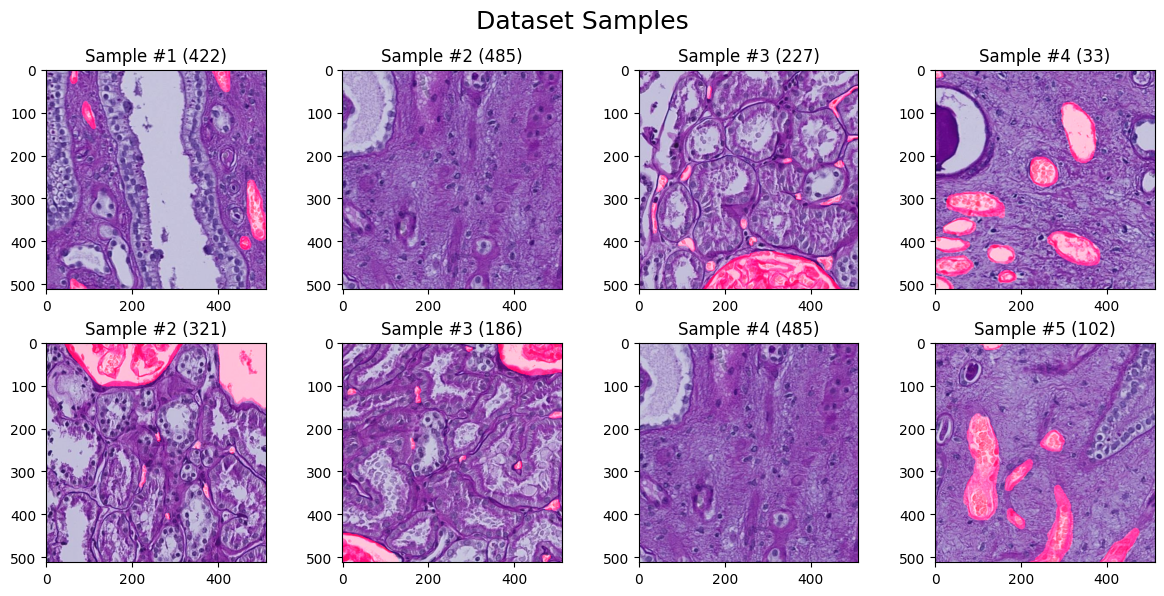

In [8]:
sample_data = HubmapDataset(return_stack=False)
n_rows = 2
n_cols = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,6), layout='tight')

for i in range(n_rows):
    for j in range(n_cols):
        n = np.random.randint(0, len(sample_data))

        img, mask = sample_data[n]

        show_masked((img_denorm(img.detach().numpy().transpose(1,2,0))),
                               (mask.squeeze()*255).astype('uint8'),
                               axs[i,j])
        axs[i,j].set_title(f'Sample #{i+j+1} ({n})')

fig.suptitle('Dataset Samples', fontsize=18)
plt.show()

In [9]:
model = smp.Unet(encoder_name='mit_b4',
                encoder_weights='imagenet',
                decoder_channels=(512, 256, 128, 64, 32),
                decoder_use_batchnorm=True,
                classes=3,
                activation=None)

model.segmentation_head[2] = nn.Softmax(dim=1)

model.load_state_dict(torch.load(MODEL_PATH))

<All keys matched successfully>

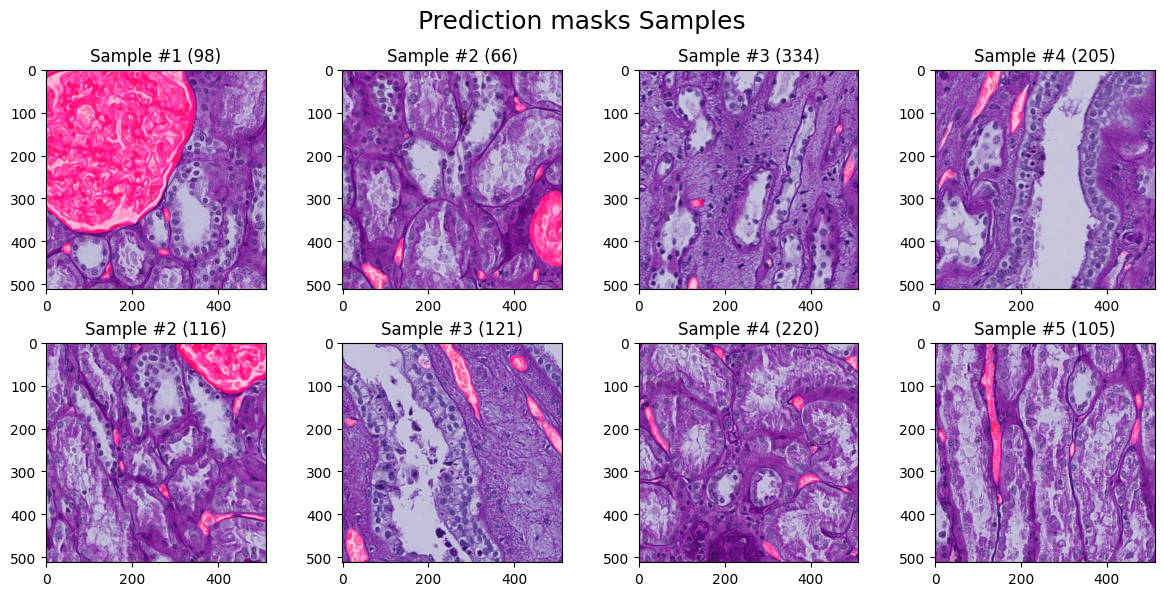

In [10]:
n_rows = 2
n_cols = 4

fig, axs = plt.subplots(n_rows, n_cols, figsize=(12,6), layout='tight')
model.eval()

for i in range(n_rows):
    for j in range(n_cols):
        n = np.random.randint(0, len(sample_data))

        img, mask = sample_data[n]

        mask_pred = model(torch.unsqueeze(img, dim=0))

        mask_pred = mask_pred.detach().numpy().squeeze()
        mask_sum = mask_pred[1] + mask_pred[2]

        show_masked((img_denorm(img.detach().numpy().transpose(1,2,0))),
                               (mask_sum.squeeze()*255).astype('uint8'),
                               axs[i,j])
        axs[i,j].set_title(f'Sample #{i+j+1} ({n})')

fig.suptitle('Prediction masks Samples', fontsize=18)
plt.show()

In [11]:
def connected_components(pred_mask):

    pred_mask = cv.morphologyEx(pred_mask, cv.MORPH_OPEN, np.ones((7,7),dtype=np.uint8))

    threshold = 0.01

    pred_mask = (pred_mask>threshold).astype(np.uint8)

    labels, labels_id, values, centroid = cv.connectedComponentsWithStats(pred_mask, 4, cv.CV_32S)

    labels = np.array(range(labels))
    predicted_stack = np.zeros((len(labels)-1, pred_mask.shape[0], pred_mask.shape[1]))

    for i in labels[1:]:
            predicted_stack[i-1] = (labels_id == i)

    return predicted_stack, labels

In [52]:
def tp_estimation(masks, pred_masks, n_instances):
    classes = np.unique(masks)[1:]
    is_corr = np.array([])
    confidence = np.array([])
    num_targets = 0

    # Для каждого класса
    for cls in classes:
        # Делим маски на инстансы, они в формате - каждый инстанс на своей маске
        cls_wise_mask = pred_masks[cls]
        cls_wise_mask = cls_wise_mask/cls_wise_mask.max()
        connected_masks, labels = connected_components(cls_wise_mask)
        n_pred = len(labels)-1
        n_targ = n_instances[cls-1]
        correct_pred = np.zeros(n_pred)
        conf = np.zeros(n_pred)

        # Каждую маску с инстансом сравниваем с таргетами по порядку, если находим того же класса
        # и с iou больше чем threshold, то помечаем как TP и удаляем таргет маску
        if n_pred:
            for i, instance in enumerate(connected_masks):
                conf[i] = np.nanmean(cls_wise_mask[instance.astype(bool)])
                if n_targ:
                    for j, msk in enumerate(masks):
                        if (msk.max() == cls) and iou_metric(torch.tensor(instance),
                                                            torch.tensor(msk//msk.max())):
                            correct_pred[i] = 1
                            pred_masks = np.delete(masks, j, axis=0)
                            break

        num_targets += n_targ
        confidence = np.concatenate((confidence, conf))
        is_corr  = np.concatenate((is_corr, correct_pred))

    return is_corr, confidence, num_targets

In [53]:
test_data = HubmapDataset(return_stack=True)

model.eval()
model.to(device)

n_instances = 0
is_correct = np.array([])
confidence = np.array([])
iou_metric = torchmetrics.JaccardIndex(task='binary', num_classes=1, threshold=0.5)
n_t = 0

for image, mask, mask_stack, n_targets in tqdm(test_data):
    image = image.to(device)
    pred_mask_stack = model(torch.unsqueeze(image, dim=0))

    pred_mask_stack = pred_mask_stack.detach().cpu().numpy().squeeze()

    is_correct_list, confidence_list, n = tp_estimation(mask_stack, pred_mask_stack, n_targets)
    n_t += n

    is_correct = np.concatenate((is_correct, is_correct_list))
    confidence = np.concatenate((confidence, confidence_list))

scores_df = pd.DataFrame.from_dict({'conf': confidence, 'TP': is_correct})

100%|██████████| 507/507 [02:04<00:00,  4.06it/s]


In [56]:
sorted_scores_df = scores_df.sort_values(by='conf', ascending=False).reset_index(drop=True)
sorted_scores_df.conf = sorted_scores_df.conf.round(2)
sorted_scores_df.TP = sorted_scores_df.TP.astype(int)
grouped_df = sorted_scores_df.groupby('conf').sum().reset_index()
grouped_df['FP'] = sorted_scores_df.groupby('conf').count().values

grouped_df.FP = grouped_df.FP - grouped_df.TP
grouped_df = grouped_df.sort_values(by='conf', ascending=False).reset_index(drop=True)

In [14]:
n_t

4206

In [57]:
grouped_df

,conf,TP,FP
0,1.00,8,80
1,0.98,1,0
2,0.96,2,0
3,0.94,8,1
4,0.93,10,2
...,...,...,...
92,0.05,5,45
93,0.04,6,28
94,0.03,2,28
95,0.02,1,13


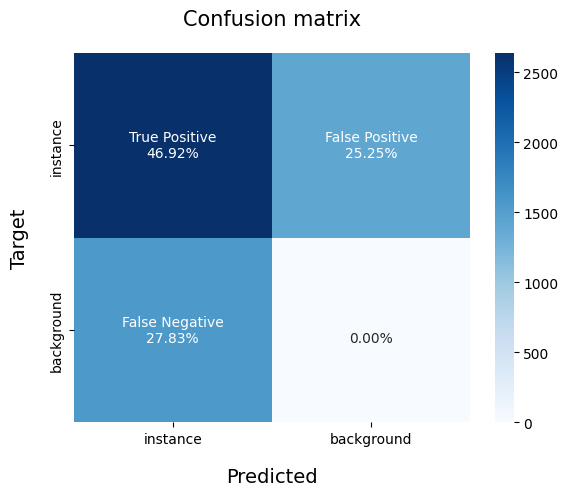

In [79]:
max_index = grouped_df.index[grouped_df.conf == 0.48].item()

tp = grouped_df.TP[:max_index].sum()
fp = grouped_df.FP[:max_index].sum()
fn = n_t - tp

cm = np.array([[tp, fp],[fn, 0]])
cm_names = ['True Positive', 'False Positive', 'False Negative', '']
cm_class = ['instance', 'background']

cm_labels = [f'{cm_name}\n{n/np.sum(cm):.2%}' for cm_name, n in zip(cm_names, cm.flatten())]
cm_labels = np.asarray(cm_labels).reshape(2,2)
fig = sns.heatmap(cm, annot=cm_labels, fmt='', cmap='Blues', xticklabels=cm_class, yticklabels=cm_class)
fig.set_title('Confusion matrix', fontsize=15, pad=20)
fig.set_xlabel('Predicted', fontsize=14, labelpad=15)
fig.set_ylabel('Target', fontsize=14, labelpad=15)

plt.show()

In [62]:
precision = np.zeros(len(grouped_df))
recall = np.zeros(len(grouped_df))
f1_score = np.zeros(len(grouped_df))

for i in grouped_df.index:
    j=i+1
    precision[i] = grouped_df.TP[:j].sum() / (grouped_df.TP[:j].sum() + grouped_df.FP[:j].sum())
    recall[i] = grouped_df.TP[:j].sum() / n_t
    f1_score[i] = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])

grouped_df['Precision'] = precision
grouped_df['Recall'] = recall
grouped_df['F1_score'] = f1_score

ap = grouped_df.Precision.mean()

In [63]:
grouped_df.head()

,conf,TP,FP,Precision,Recall,F1_score
0,1.00,8,80,0.090909,0.001902,0.003726
1,0.98,1,0,0.101124,0.002140,0.004191
2,0.96,2,0,0.120879,0.002615,0.005120
3,0.94,8,1,0.190000,0.004517,0.008825
4,0.93,10,2,0.258929,0.006895,0.013432


In [75]:
grouped_df.conf[grouped_df.Recall == grouped_df.Recall.max()].values

array([0.02, 0.01])

mAP@50: 0.615
F1 score: 0.643


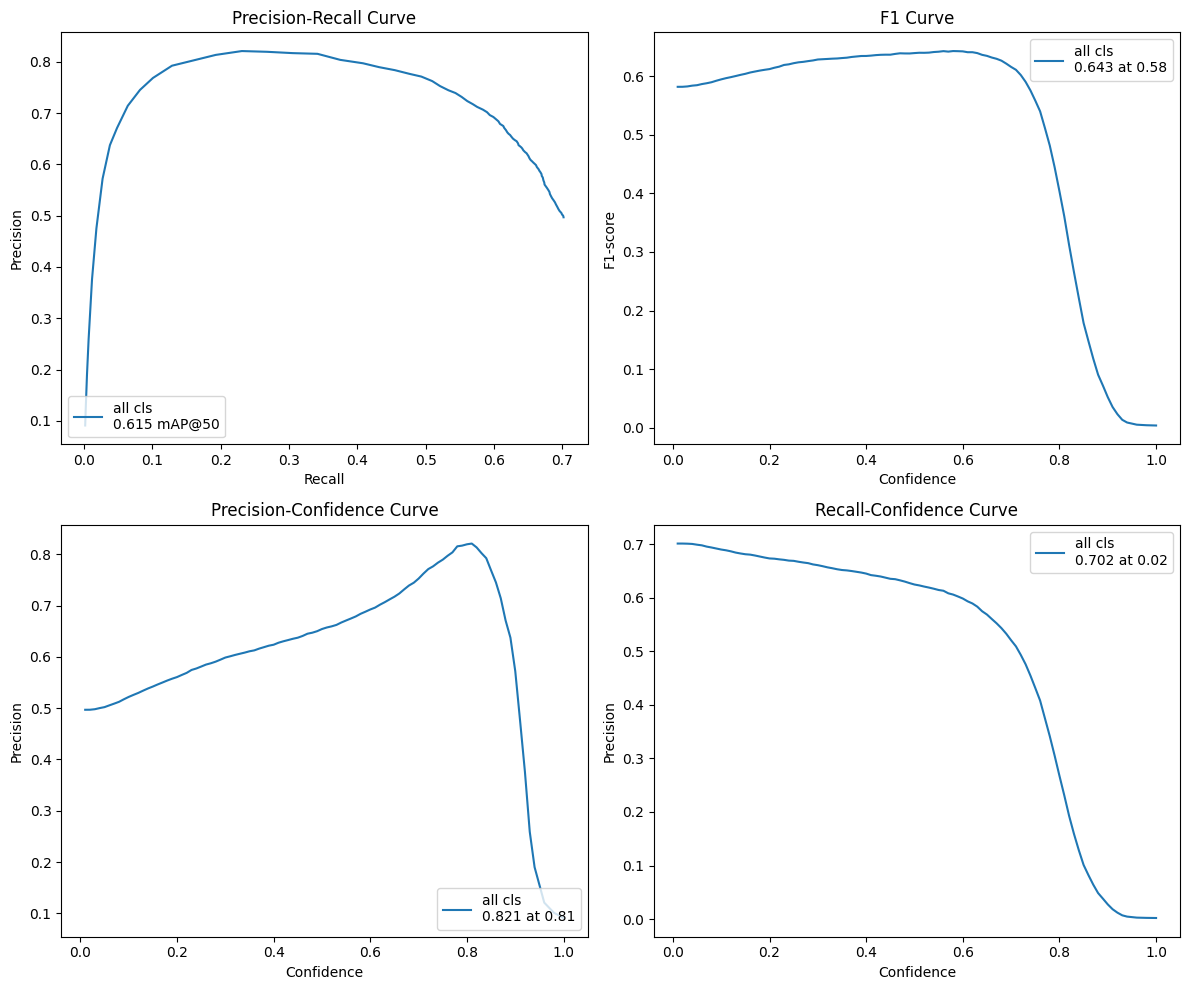

In [78]:
fig, axs = plt.subplots(2, 2, figsize=(12,10), layout='tight')

axs[0,0].plot(grouped_df.Recall, grouped_df.Precision, label=f'all cls\n{ap:.3f} mAP@50')
axs[0,0].set_xlabel('Recall')
axs[0,0].set_ylabel('Precision')
axs[0,0].set_title('Precision-Recall Curve')
axs[0,0].legend(loc='lower left')

axs[0,1].plot(grouped_df.conf, grouped_df.F1_score, label=f'all cls\n{grouped_df.F1_score.max():.3f} at \
{grouped_df.conf[grouped_df.F1_score == grouped_df.F1_score.max()].item()}')
axs[0,1].set_xlabel('Confidence')
axs[0,1].set_ylabel('F1-score')
axs[0,1].set_title('F1 Curve')
axs[0,1].legend(loc='upper right')

axs[1,0].plot(grouped_df.conf, grouped_df.Precision, label=f'all cls\n{grouped_df.Precision.max():.3f} at \
{grouped_df.conf[grouped_df.Precision == grouped_df.Precision.max()].item()}')
axs[1,0].set_xlabel('Confidence')
axs[1,0].set_ylabel('Precision')
axs[1,0].set_title('Precision-Confidence Curve')
axs[1,0].legend(loc='lower right')

axs[1,1].plot(grouped_df.conf, grouped_df.Recall, label=f'all cls\n{grouped_df.Recall.max():.3f} at \
{grouped_df.conf[grouped_df.Recall == grouped_df.Recall.max()].values[0]}')
axs[1,1].set_xlabel('Confidence')
axs[1,1].set_ylabel('Precision')
axs[1,1].set_title('Recall-Confidence Curve')
axs[1,1].legend(loc='upper right')

print(f'mAP@50: {ap:.3f}\nF1 score: {grouped_df.F1_score.max():.3f}')
plt.show()

uint8 float32


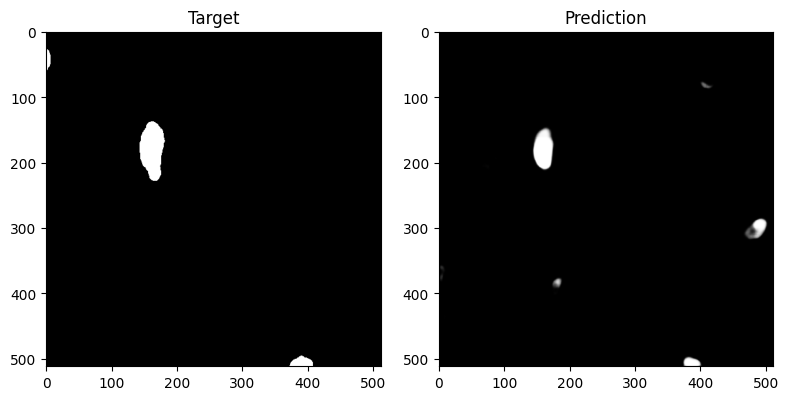

In [49]:
model.eval()
model.to(device)

image, mask, mask_stack, _ = test_data[0]
pred_mask_stack = model(torch.unsqueeze(image.to(device), dim=0))
pred_mask_stack = pred_mask_stack.detach().cpu().numpy().squeeze()

fig, axs = plt.subplots(1, 2, figsize=(8,4), layout='tight')

axs[0].imshow(np.sum(mask_stack, axis=0), cmap='gray')
axs[0].set_title('Target')

axs[1].imshow(np.sum(pred_mask_stack[1:], axis=0), cmap='gray')
axs[1].set_title('Prediction')

print(mask_stack.dtype, pred_mask_stack.dtype)
plt.show()

In [44]:
np.unique(mask_stack)[1:]

array([1, 2], dtype=uint8)

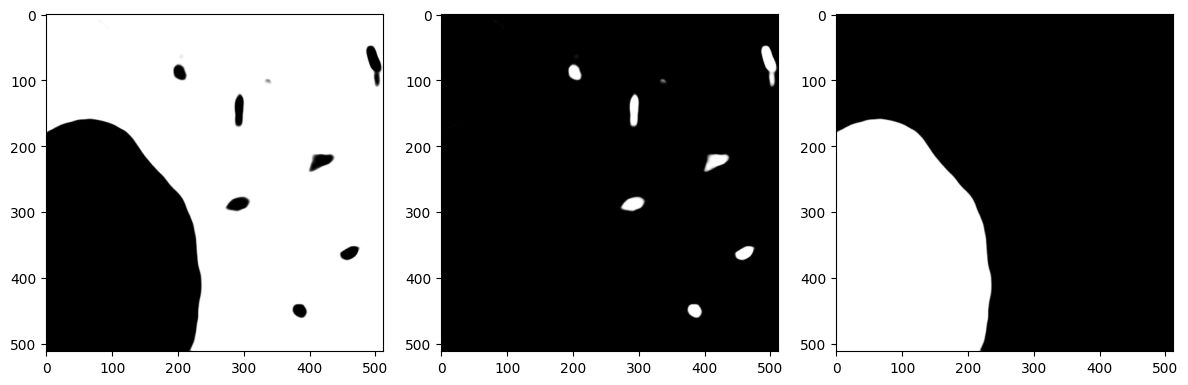

In [42]:
fig, axs = plt.subplots(1, 3, figsize=(12,4), layout='tight')

for i in range(3):
    axs[i].imshow(pred_mask_stack[i], cmap='gray')

plt.show()